# Adversarial Search: Playing Connect 4

Student Name: Ahmed Abdul Naoman

I have used the following AI tools: deepseek

I understand that my submission needs to be my own work: aan

## Learning Outcomes

* Implement adversarial search algorithms for strategic game play.
* Analyze and optimize search in complex game spaces.
* Design effective heuristic evaluation functions.
* Compare performance across different agent strategies.
* Evaluate algorithmic trade-offs between decision quality and efficiency.

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

### Initial State
The initial state of the Connect 4 game is an empty board, typically a 6x7 grid, where no discs have been played yet. We'll represent the empty slots with `0`, player 1's discs with `1`, and player -1's discs with `-1`.

### Actions
An action in Connect 4 consists of dropping a disc into one of the available columns. A column is available if it is not yet full. The `actions(state)` function will return a list of column indices where a disc can be placed.

### Transition Model (Result Function)
The `result(state, player, action)` function takes the current board `state`, the `player` making the move, and the chosen `action` (column). It returns a new board state where the player's disc has been placed in the lowest available slot of the chosen column. It's crucial that this function returns a *new* state without modifying the original.

### Goal State (Terminal State and Utility)
*   **Terminal State**: A state is terminal if the game has ended. This occurs when a player has formed a line of four (horizontally, vertically, or diagonally), or when the entire board is filled, resulting in a draw.
*   **Utility**: The `utility(state, player)` function assigns a numerical value to a terminal state from the perspective of the given `player`. For a win, it's `1`; for a loss, it's `-1`; and for a draw, it's `0`.

In [184]:
import numpy as np

def empty_board(rows=6, cols=7):
    """Creates an empty Connect 4 board."""
    return np.full(shape=(rows, cols), fill_value=0, dtype=int)

def actions(board):
    """Returns valid columns where a disc can be dropped."""
    # Top row must be empty for a column to be valid.
    return [col for col in range(board.shape[1]) if board[0, col] == 0]

def result(board, player, action):
    """Returns the new board state after player drops a disc in the specified column."""
    if action not in actions(board):
        raise ValueError("Invalid action: column is full or out of bounds")

    new_board = board.copy()
    rows = new_board.shape[0]
    # Find the lowest available row in the chosen column
    for row in range(rows - 1, -1, -1):
        if new_board[row, action] == 0:
            new_board[row, action] = player
            return new_board
    return new_board # Should not be reached if action is valid

def check_win(board, player):
    """Checks if the given player has won the game."""
    rows, cols = board.shape
    winning_line = np.array([player] * 4)

    # Check horizontal wins
    for r in range(rows):
        for c in range(cols - 3):
            if np.array_equal(board[r, c:c+4], winning_line):
                return True

    # Check vertical wins
    for c in range(cols):
        for r in range(rows - 3):
            if np.array_equal(board[r:r+4, c], winning_line):
                return True

    # Check diagonal wins (positive slope)
    for r in range(rows - 3):
        for c in range(cols - 3):
            if np.array_equal(np.diag(board[r:r+4, c:c+4]), winning_line):
                return True

    # Check diagonal wins (negative slope)
    for r in range(3, rows):
        for c in range(cols - 3):
            if np.array_equal(np.diag(np.fliplr(board[r-3:r+1, c:c+4])), winning_line):
                return True

    return False

def terminal(board):
    """Checks if the game is in a terminal state (win or draw)."""
    if check_win(board, 1) or check_win(board, -1):
        return True
    # Check for a draw (board full and no win)
    if np.all(board != 0):
        return True
    return False

def utility(board, player):
    """Returns the utility of a terminal state for the given player."""
    if check_win(board, player):
        return 1
    elif check_win(board, -player): # Opponent won
        return -1
    else: # It's a draw
        return 0


How big is the state space? Give an estimate and explain it.

The state space of Connect 4 is the total number of possible board configurations. For a standard 6 rows x 7 columns board, there are 42 positions. Each position can be empty, or occupied by player 1, or player -1. So, a naive upper bound would be $3^{42}$.

However, this is a significant overestimate because:
1.  **Gravity:** Discs fall to the lowest available spot, meaning the board must always be 'bottom-heavy'. There cannot be floating discs.
2.  **Turns:** The number of pieces for player 1 and player -1 must either be equal, or player 1 must have exactly one more piece than player -1 (since player 1 always starts).
3.  **Terminal States:** Once a player wins, the game ends, and further moves are not part of the reachable state space from that point.

A more accurate estimate, factoring in gravity and turn constraints, suggests the total number of legal positions is around **$4.5 \times 10^{12}$** (trillion) unique states. This is still a massive number, indicating that exploring the entire state space is computationally infeasible.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree for Connect 4 represents all possible sequences of moves from the initial state until a terminal state (win, loss, or draw). Unlike the state space, which counts unique board configurations, the game tree counts paths (sequences of moves). While the number of unique states is immense, the game tree is vastly larger.

Estimating the exact size of the full game tree for Connect 4 is extremely difficult, as it involves branching factors (number of available moves at each step) and game depth. However, we know:

*   **Average Branching Factor:** In Connect 4, the average number of available moves per turn is approximately 5-6 (since there are 7 columns, but some may be full, and early in the game all are available).
*   **Maximum Game Depth:** A Connect 4 game can last up to 42 moves (the total number of cells on the board), though most games end much sooner.

If we consider a simplified scenario with an average branching factor of 6 and a maximum depth of 42, a naive upper bound for the game tree size would be $6^{42}$. This number is astronomically large, far exceeding the number of atoms in the observable universe, making it impossible to explore the entire game tree. (For comparison, $10^{80}$ is a common estimate for atoms in the universe).

However, minimax search with alpha-beta pruning significantly reduces the explored portion of the tree by cutting off branches that cannot affect the final decision. Even with pruning, the search depth for a full Connect 4 board remains a major challenge, which is why limited-depth searches and heuristic evaluation functions are crucial for practical Connect 4 AI.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [185]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

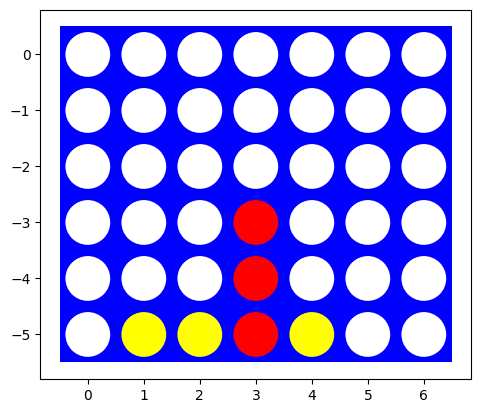

In [186]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [187]:
import numpy as np

def actions(board):
    return [c for c in range(board.shape[1]) if board[0, c] == 0]


def result(board, player, action):
    new_board = board.copy()
    rows = new_board.shape[0]

    for r in range(rows - 1, -1, -1):
        if new_board[r, action] == 0:
            new_board[r, action] = player
            return new_board

    raise ValueError("Invalid action: column is full.")


def check_win(board, player):
    rows, cols = board.shape
    target = [player] * 4

    # Horizontal
    for r in range(rows):
        for c in range(cols - 3):
            if list(board[r, c:c+4]) == target:
                return True

    # Vertical
    for r in range(rows - 3):
        for c in range(cols):
            if list(board[r:r+4, c]) == target:
                return True

    # Diagonal down-right
    for r in range(rows - 3):
        for c in range(cols - 3):
            if [board[r+i, c+i] for i in range(4)] == target:
                return True

    # Diagonal up-right
    for r in range(3, rows):
        for c in range(cols - 3):
            if [board[r-i, c+i] for i in range(4)] == target:
                return True

    return False


def terminal(board):
    """
    Return True if game is over: win or draw.
    """
    if check_win(board, 1) or check_win(board, -1):
        return True
    if np.all(board != 0):
        return True
    return False


def utility(board, player):
    if check_win(board, player):
        return 1
    elif check_win(board, -player):
        return -1
    else:
        return 0

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [188]:
import random

def random_player(board, player = 1):
    """An agent that plays randomly by selecting a valid column."""
    valid_actions = actions(board)
    if not valid_actions:
        return None # No valid moves
    return random.choice(valid_actions)

current_board = empty_board()
print("Random player's move (player 1):", random_player(current_board, 1))
next_board = result(current_board, 1, random_player(current_board, 1))
print("\nBoard after random move:\n", next_board)


Random player's move (player 1): 0

Board after random move:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [206]:
def play_game(agent1, agent2, board_shape=(6, 7), verbose=False):
    board = empty_board(board_shape)
    current_player = 1 # Player 1 starts
    turn = 0
    if verbose: print("\n--- New Game ---")
    if verbose: print("Initial Board:\n", board)

    while not terminal(board):
        turn += 1
        if current_player == 1:
            action = agent1(board, current_player)
        else:
            action = agent2(board, current_player)

        if action is None: # No valid moves for the current player (should not happen in Connect 4 unless board is full)
            if verbose: print(f"Player {current_player} has no valid moves. Game ends in a draw.")
            return 0 # Draw

        board = result(board, current_player, action)
        if verbose: print(f"Player {current_player} plays column {action}")
        if verbose: print(f"Board after {turn} turns:\n", board)

        if check_win(board, current_player):
            if verbose: print(f"Player {current_player} wins!")
            return current_player

        if np.all(board != 0): # Check for draw if board is full and no win
            if verbose: print("Board is full. It's a draw!")
            return 0

        current_player *= -1 # Switch player
    return utility(board, 1)
#Simulation
num_games = 1000
player1_wins = 0
player_minus1_wins = 0
draws = 0

print(f"Simulating {num_games} games between two random agents...")

for i in range(num_games):
    game_result = play_game(random_player, random_player)
    if game_result == 1:
        player1_wins += 1
    elif game_result == -1:
        player_minus1_wins += 1
    else:
        draws += 1

print(f"\nSimulation Results ({num_games} games)")
print(f"Player 1 (Red) Wins: {player1_wins}")
print(f"Player -1 (Yellow) Wins: {player_minus1_wins}")
print(f"Draws: {draws}")
print(f"Total games: {player1_wins + player_minus1_wins + draws}")


Simulating 1000 games between two random agents...

Simulation Results (1000 games)
Player 1 (Red) Wins: 541
Player -1 (Yellow) Wins: 453
Draws: 6
Total games: 1000


Over 1000 games, Player 1 (red) won 541 times, Player -1 (yellow) won 453 times, and there was 6 draws.
Since both agents play randomly but Player 1 always moves first, it’s expected that Player 1 has a slight advantage, which is reflected in the higher win count.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [190]:
import math

def minimax_value(board, player, alpha, beta, depth):
    """Return minimax value with depth cutoff + heuristic."""

    # Terminal state or depth limit reached
    if terminal(board) or depth == 0:
        return heuristic(board, player)  # use your heuristic function here

    if player == 1:   # maximizing player
        best = -math.inf
        for col in actions(board):
            child = result(board, player, col)
            val = minimax_value(child, -player, alpha, beta, depth-1)
            best = max(best, val)
            alpha = max(alpha, best)
            if beta <= alpha:
                break
        return best

    else:  # minimizing player
        best = math.inf
        for col in actions(board):
            child = result(board, player, col)
            val = minimax_value(child, -player, alpha, beta, depth-1)
            best = min(best, val)
            beta = min(beta, best)
            if beta <= alpha:
                break
        return best


def minimax_move(board, player=1, depth=4):
    """Choose the best move using alpha-beta with depth cutoff."""
    best_action = None

    if player == 1:
        best_val = -math.inf
        alpha, beta = -math.inf, math.inf
        for col in actions(board):
            child = result(board, player, col)
            val = minimax_value(child, -player, alpha, beta, depth-1)
            if val > best_val:
                best_val = val
                best_action = col
            alpha = max(alpha, best_val)

    else:
        best_val = math.inf
        alpha, beta = -math.inf, math.inf
        for col in actions(board):
            child = result(board, player, col)
            val = minimax_value(child, -player, alpha, beta, depth-1)
            if val < best_val:
                best_val = val
                best_action = col
            beta = min(beta, best_val)

    return best_action


class MinimaxAgent:
    """Depth-limited minimax agent."""

    def __init__(self, name="Minimax", depth=4):
        self.name = name
        self.depth = depth

    def __call__(self, board, player=1):
        return minimax_move(board, player, depth=self.depth)


print("Minimax search with alpha-beta pruning + depth cutoff is ready.")

Minimax search with alpha-beta pruning + depth cutoff is ready.


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [191]:
def print_board(board):
    for row in board:
        print(row)
    print()

agent = MinimaxAgent()   # alphabeta +heuristic, depth-limited

tests = [
    (board1, player1, "P1 horizontal win"),
    (board2, player2, "P-1 block horizontal"),
    (board3, player3, "P1 vertical win"),
    (board4, player4, "P-1 block vertical"),
    (board5, player5, "P1 diagonal win")
]

for i, (board, player, desc) in enumerate(tests, start=1):

    print(f"\n=== Test {i}: {desc} ===")
    print("Initial board:")
    print_board(board)

    move = agent(board, player)   # depth cutoff included internally
    print(f"Player {player} chooses column: {move}")

    if move is not None:
        new_board = result(board, player, move)
        print("Board after move:")
        print_board(new_board)
    else:
        print("No legal move available.")


=== Test 1: P1 horizontal win ===
Initial board:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 1 1 1 0 0 0]

Player 1 chooses column: 3
Board after move:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 1 1 1 0 0 0]


=== Test 2: P-1 block horizontal ===
Initial board:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 1 1 1 0 0 0]

Player -1 chooses column: 6
Board after move:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[ 0  1  1  1  0  0 -1]


=== Test 3: P1 vertical win ===
Initial board:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[ 0 -1 -1 -1  0  0  0]

Player 1 chooses column: 0
Board after move:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[ 1 -1 -1 -1  0  0  0]


=== Test 4: P-1 block vertical ===
Initial board:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 

Even with alphabeta pruning, minimax becomes slower as the board gets wider and taller because the branching factor increases. A 4×4 board has very few possible actions, but a 6×7 board starts with 7 legal moves and the search tree can grow enormously.

A depth-4 search already explores thousands of positions.
A full, non-cutoff minimax on a 6×7 board would require exploring on the order of 7^{42} possible states, which is completely impossible to compute.

So even though my depth-limited version runs reasonably fast on small boards, running full minimax on a standard 6×7 Connect-4 board is not feasible.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [192]:
def measure_move_time(rows, cols):
    board = np.zeros((rows, cols), dtype=int)
    agent = MinimaxAgent()

    start = time.time()
    _ = agent(board, player=1)
    end = time.time()

    return end - start

sizes = [
    (4,4),
    (4,5),
    (5,5),
    (5,6),
    (6,7)  # standard Connect-4
]

print("Measuring minimax (with depth cutoff) move time:\n")
for r, c in sizes:
    t = measure_move_time(r, c)
    print(f"{r}×{c} board → {t:.4f} seconds")

Measuring minimax (with depth cutoff) move time:

4×4 board → 0.0204 seconds
4×5 board → 0.0578 seconds
5×5 board → 0.0796 seconds
5×6 board → 0.2058 seconds
6×7 board → 0.5768 seconds


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [193]:
def ordered_actions(board):
    """Return legal actions sorted to try center columns first."""
    cols = actions(board)
    center = board.shape[1] // 2
    return sorted(cols, key=lambda c: abs(c - center))

Minimax With Move Ordering

In [194]:
def minimax_value_ordered(board, player, alpha, beta, depth):
    if terminal(board) or depth == 0:
        return heuristic(board, player)

    if player == 1:  # maximizing
        best = -math.inf
        for col in ordered_actions(board):    # <--- ordered moves
            child = result(board, player, col)
            val = minimax_value_ordered(child, -player, alpha, beta, depth-1)
            best = max(best, val)
            alpha = max(alpha, best)
            if beta <= alpha:
                break
        return best

    else:  # minimizing
        best = math.inf
        for col in ordered_actions(board):    # <--- ordered moves
            child = result(board, player, col)
            val = minimax_value_ordered(child, -player, alpha, beta, depth-1)
            best = min(best, val)
            beta = min(beta, best)
            if beta <= alpha:
                break
        return best

In [195]:
def minimax_move_ordered(board, player=1, depth=4):
    best_move = None

    if player == 1:
        best_val = -math.inf
        for col in ordered_actions(board):
            child = result(board, player, col)
            val = minimax_value_ordered(child, -player, -math.inf, math.inf, depth-1)
            if val > best_val:
                best_val = val
                best_move = col

    else:
        best_val = math.inf
        for col in ordered_actions(board):
            child = result(board, player, col)
            val = minimax_value_ordered(child, -player, -math.inf, math.inf, depth-1)
            if val < best_val:
                best_val = val
                best_move = col

    return best_move

Timing Comparison (No Ordering vs Ordering)

In [196]:
import time

def measure(agent_func, board, depth=4):
    start = time.time()
    agent_func(board, 1, depth)
    return time.time() - start

# Fix: pass shape tuple into empty_board
boards_to_test = [
    empty_board((4,4)),
    empty_board((4,5)),
    empty_board((5,5)),
]

print("Timing comparison (seconds):\n")
print("Board\t\tNo Ordering\tWith Ordering")

for b in boards_to_test:
    t1 = measure(minimax_move, b, depth=4)
    t2 = measure(minimax_move_ordered, b, depth=4)
    print(f"{b.shape}\t{t1:.4f}\t\t{t2:.4f}")

Timing comparison (seconds):

Board		No Ordering	With Ordering
(4, 4)	0.0112		0.0330
(4, 5)	0.0678		0.0606
(5, 5)	0.0780		0.1108


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

Starting from an empty board is basically the worst possible situation for minimax. At the beginning of the game, every column is available, the branching factor is huge, and the game can go all the way to 42 moves. If you try to explore the entire game tree from this position, you’d be looking at something on the scale of 7^{42} possible states, which is completely impossible to search through, even with alpha–beta pruning.

To make the early moves actually feasible, I don’t let minimax search all the way to the end. Instead, I apply a depth cutoff during the first few moves (usually depth 4–6) and use my heuristic evaluation function to estimate the board value when the cutoff is reached. This still lets the agent catch short-term wins or threats without blowing up the computation.

I also use move ordering, where I explore center columns first. This helps alpha–beta pruning cut off more of the tree and makes the search a lot faster.

Putting these together depth limits, heuristics, and move ordering keeps the first few moves fast and still produces good, sensible decisions.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [197]:
def random_agent(board, player):
    legal = actions(board)
    return np.random.choice(legal) if legal else None

def play_game(agent1, agent2, rows=4, cols=4):
    board = empty_board((rows, cols))
    player = 1  # Minimax goes first

    while True:
        move = agent1(board, player) if player == 1 else agent2(board, player)
        if move is None:
            return "draw"

        board = result(board, player, move)

        if terminal(board):
            if utility(board, 1) == 1:
                return "minimax_win"
            elif utility(board, 1) == -1:
                return "random_win"
            else:
                return "draw"

        player *= -1  # switch player


# Run multiple games
minimax = MinimaxAgent()  # depth cutoff built inside your agent
randomA = random_agent

results = {"minimax_win": 0, "random_win": 0, "draw": 0}

N = 50  # play 50 games
for _ in range(N):
    outcome = play_game(minimax, randomA, rows=4, cols=4)
    results[outcome] += 1

print(f"Results over {N} games:")
print(results)

Results over 50 games:
{'minimax_win': 20, 'random_win': 3, 'draw': 27}


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [198]:
import numpy as np

def heuristic(board, player=1):
    # If the game is already over, just use the true utility
    if terminal(board):
        return utility(board, player)

    rows, cols = board.shape
    opp = -player
    score = 0

    def eval_window(window):
        """Score a 4-cell window."""
        window = np.array(window)
        cnt_p = np.count_nonzero(window == player)
        cnt_o = np.count_nonzero(window == opp)
        cnt_0 = np.count_nonzero(window == 0)

        # If both pplayers are in this window, it's kinda neutral
        if cnt_p > 0 and cnt_o > 0:
            return 0

        s = 0
        #Favour our potential lines
        if cnt_p == 3 and cnt_0 == 1:
            s += 5
        elif cnt_p == 2 and cnt_0 == 2:
            s += 2
        elif cnt_p == 1 and cnt_0 == 3:
            s += 0.5

        #punish opponent's potential lines
        if cnt_o == 3 and cnt_0 == 1:
            s -= 5
        elif cnt_o == 2 and cnt_0 == 2:
            s -= 2
        elif cnt_o == 1 and cnt_0 == 3:
            s -= 0.5

        return s

    #horizontal windows
    for r in range(rows):
        for c in range(cols - 3):
            window = board[r, c:c+4]
            score += eval_window(window)

    #Vertical windows
    for c in range(cols):
        for r in range(rows - 3):
            window = board[r:r+4, c]
            score += eval_window(window)

    #Diagonal (down-right)
    for r in range(rows - 3):
        for c in range(cols - 3):
            window = [board[r+i, c+i] for i in range(4)]
            score += eval_window(window)

    #diagonal (up-right)
    for r in range(3, rows):
        for c in range(cols - 3):
            window = [board[r-i, c+i] for i in range(4)]
            score += eval_window(window)

    # Normalise to [-1, 1]. 50 is just a safe-ish cap for typical boards.
    max_abs = 50.0
    score = max(-max_abs, min(max_abs, score))
    return score / max_abs

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [199]:
import math

def minimax_heuristic_search(board, current_player, max_player, depth, max_depth, alpha, beta):
    # Terminal state: use true utility
    if terminal(board):
        return utility(board, max_player)

    # Depth cutoff: use heuristic
    if depth == max_depth:
        return heuristic(board, max_player)

    # Maximizing for max_player, minimizing for the opponent
    if current_player == max_player:
        value = -math.inf
        for col in actions(board):
            new_board = result(board, current_player, col)
            child_value = minimax_heuristic_search(
                new_board,
                -current_player,
                max_player,
                depth + 1,
                max_depth,
                alpha,
                beta
            )
            value = max(value, child_value)
            alpha = max(alpha, value)
            if beta <= alpha:
                break
        return value
    else:
        value = math.inf
        for col in actions(board):
            new_board = result(board, current_player, col)
            child_value = minimax_heuristic_search(
                new_board,
                -current_player,
                max_player,
                depth + 1,
                max_depth,
                alpha,
                beta
            )
            value = min(value, child_value)
            beta = min(beta, value)
            if beta <= alpha:
                break
        return value


class HeuristicMinimaxAgent:
    def __init__(self, max_depth=4):
        # how far we search before using the heuristic
        self.max_depth = max_depth

    def __call__(self, board, player=1):

        return self.make_move(board, player)

    def make_move(self, board, player=1):
        max_player = player
        best_move = None

        # If no legal moves, return None
        legal_moves = actions(board)
        if not legal_moves:
            return None

        # Root alpha-beta loop
        if max_player == 1:
            best_value = -math.inf
            alpha, beta = -math.inf, math.inf
            for col in legal_moves:
                new_board = result(board, max_player, col)
                value = minimax_heuristic_search(
                    new_board,
                    -max_player,
                    max_player,
                    depth=1,
                    max_depth=self.max_depth,
                    alpha=alpha,
                    beta=beta
                )
                if value > best_value:
                    best_value = value
                    best_move = col
                alpha = max(alpha, best_value)
        else:
            best_value = math.inf
            alpha, beta = -math.inf, math.inf
            for col in legal_moves:
                new_board = result(board, max_player, col)
                value = minimax_heuristic_search(
                    new_board,
                    -max_player,
                    max_player,
                    depth=1,
                    max_depth=self.max_depth,
                    alpha=alpha,
                    beta=beta
                )
                if value < best_value:
                    best_value = value
                    best_move = col
                beta = min(beta, best_value)

        return best_move

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [200]:


heur_agent = HeuristicMinimaxAgent(max_depth=4)

scenarios = [
    (test_board_1,  1, "P1 should win horizontally"),
    (test_board_2, -1, "P-1 should block P1 horizontal win"),
    (test_board_3,  1, "P1 should win vertically"),
    (test_board_4, -1, "P-1 should block P1 vertical win"),
    (test_board_5,  1, "P1 should win on diagonal"),
]

for i, (board, player, note) in enumerate(scenarios, start=1):
    print(f"\n=== Scenario {i} ===")
    print(note)
    print(f"Player to move: {player}")
    print("Initial board:")
    print(board)

    move = heur_agent(board, player)
    print(f"Heuristic agent chooses column: {move}")

    if move is not None:
        new_board = result(board, player, move)
        print("Resulting board:")
        print(new_board)
    else:
        print("No legal move found (probably full column/board).")

print("\nHeuristic agent tests done.")


=== Scenario 1 ===
P1 should win horizontally
Player to move: 1
Initial board:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 1 1 0 0 0]]
Heuristic agent chooses column: 0
Resulting board:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 1 1 1 0 0 0]]

=== Scenario 2 ===
P-1 should block P1 horizontal win
Player to move: -1
Initial board:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 1 1 0 0 0]]
Heuristic agent chooses column: 0
Resulting board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [-1  1  1  1  0  0  0]]

=== Scenario 3 ===
P1 should win vertically
Player to move: 1
Initial board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0 -1 -1 -1  0  0  0]]
Heuristic agent chooses column: 3
Resulting board:
[

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [201]:
import time

heur_agent = HeuristicMinimaxAgent(max_depth=4)

def time_one_move(board_shape, player=1, trials=3):
    """Rough timing for one heuristic minimax move on an empty board."""
    total = 0.0
    for _ in range(trials):
        board = empty_board(board_shape)
        start = time.perf_counter()
        _ = heur_agent(board, player)
        end = time.perf_counter()
        total += (end - start)
    return total / trials

# start with 4 columns and increase
board_shapes = [
    (6, 4),  # 6 rows, 4 columns
    (6, 5),
    (6, 6),
    (6, 7),  # standard width
]

print(f"Heuristic minimax, max_depth = {heur_agent.max_depth}")
print("Average time per move on empty boards:\n")

for shape in board_shapes:
    avg_t = time_one_move(shape, player=1, trials=3)
    print(f"Board {shape[0]}x{shape[1]}: {avg_t:.4f} seconds per move")

Heuristic minimax, max_depth = 4
Average time per move on empty boards:

Board 6x4: 0.0190 seconds per move
Board 6x5: 0.1014 seconds per move
Board 6x6: 0.2974 seconds per move
Board 6x7: 0.6510 seconds per move


As we add more columns, the branching factor grows (there are more legal actions per state), so the number of nodes explored by minimax with depth d grows roughly like b^d. That’s why even with a fixed cutoff depth the move time goes up as we widen the board.

On a full 6×7 board with a larger depth limit the runtime would blow up really fast, so using a cutoff depth (and a heuristic eval) is kind of necessary to keep the agent playable in real time.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [202]:
# Your code/ answer goes here.# Playtime: heuristic vs heuristic with different depths

def play_game_heuristic(agent1, agent2, board_shape=(6, 7), verbose=True):
    """Let two heuristic agents play one game on a given board size."""
    board = empty_board(board_shape)
    current_player = 1   # player 1 starts
    turn = 0

    if verbose:
        print(f"\n--- Heuristic vs Heuristic on {board_shape[0]}x{board_shape[1]} ---")
        print("Initial board:\n", board)

    while not terminal(board):
        turn += 1

        if current_player == 1:
            action = agent1(board, current_player)
        else:
            action = agent2(board, current_player)

        if action is None:
            # no legal moves -> draw (should only happen on full board)
            if verbose:
                print(f"Player {current_player} has no legal moves. Draw.")
            return 0

        board = result(board, current_player, action)

        if verbose:
            print(f"\nTurn {turn}: player {current_player} plays column {action}")
            print(board)

        if check_win(board, current_player):
            if verbose:
                print(f"\nGame over: player {current_player} wins.")
            return current_player

        # switch player
        current_player *= -1

    # full board, no winner
    if verbose:
        print("\nGame over: draw (board full).")
    return 0


# two heuristic agents with different cutoff depths
agent_depth3 = HeuristicMinimaxAgent(max_depth=3)
agent_depth5 = HeuristicMinimaxAgent(max_depth=5)

# let them play once on a "reasonable" board (6x7 standard)
winner = play_game_heuristic(agent_depth3, agent_depth5, board_shape=(6, 7), verbose=True)

if winner == 1:
    print("\nResult: player 1 (depth 3) wins.")
elif winner == -1:
    print("\nResult: player -1 (depth 5) wins.")
else:
    print("\nResult: draw.")


--- Heuristic vs Heuristic on 6x7 ---
Initial board:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

Turn 1: player 1 plays column 2
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]

Turn 2: player -1 plays column 6
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 -1]]

Turn 3: player 1 plays column 3
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0 -1]]

Turn 4: player -1 plays column 0
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  1  1  0  0 -1]]

Turn 5: player 1 plays column 4
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1  0  1  1  1 

As we add more columns, the branching factor grows (there are more legal actions per state), so the number of nodes explored by minimax with depth d grows roughly like b^d. That’s why even with a fixed cutoff depth the move time goes up as we widen the board.

On a full 6×7 board with a larger depth limit the runtime would blow up really fast, so using a cutoff depth (and a heuristic eval) is kind of necessary to keep the agent playable in real time.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [203]:
import random
import math

def random_rollout(board, current_player):
    """
    Play out a game to the end with random moves.
    Returns utility from the perspective of the player who started the rollout.
    """
    root_player = current_player
    temp_board = board.copy()

    while not terminal(temp_board):
        valid_moves = actions(temp_board)
        if not valid_moves:
            break
        move = random.choice(valid_moves)
        temp_board = result(temp_board, current_player, move)
        current_player *= -1  # switch player

    return utility(temp_board, root_player)


def monte_carlo_move(board, player, num_rollouts=200):
    """
    Pure Monte Carlo: for each legal move, run random rollouts and pick the move
    with the best average utility for `player`.
    """
    valid_moves = actions(board)
    if not valid_moves:
        return None

    best_move = None
    best_score = -math.inf

    for move in valid_moves:
        next_board = result(board, player, move)
        # if this move already wins, just take it
        if check_win(next_board, player):
            return move

        total_score = 0
        for _ in range(num_rollouts):
            total_score += random_rollout(next_board, -player) * -1  # flip back to player's view

        avg_score = total_score / num_rollouts

        if avg_score > best_score:
            best_score = avg_score
            best_move = move

    return best_move


class MonteCarloAgent:
    def __init__(self, num_rollouts=200):
        self.num_rollouts = num_rollouts

    def __call__(self, board, player=1):
        # keep the same signature as random_player / minimax agents
        return monte_carlo_move(board, player, self.num_rollouts)

In [204]:
mc_agent = MonteCarloAgent(num_rollouts=300)

test_positions = [
    ("Scenario 1: P1 win horizontal",    test_board_1,  1),
    ("Scenario 2: P-1 block horizontal", test_board_2, -1),
    ("Scenario 3: P1 win vertical",      test_board_3,  1),
    ("Scenario 4: P-1 block vertical",   test_board_4, -1),
    ("Scenario 5: P1 win diagonal",      test_board_5,  1),
]

for name, board, current_player in test_positions:
    print("\n" + name)
    print("Current player:", current_player)
    print("Board:\n", board)

    move = mc_agent(board, current_player)
    print("Monte Carlo chosen move (column):", move)

    if move is not None:
        new_board = result(board, current_player, move)
        print("Resulting board:\n", new_board)
        if check_win(new_board, current_player):
            print("→ This move wins for player", current_player)
        else:
            print("→ This move does not win immediately (likely a blocking / setup move).")
    else:
        print("No legal move found.")


Scenario 1: P1 win horizontal
Current player: 1
Board:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 1 1 0 0 0]]
Monte Carlo chosen move (column): 0
Resulting board:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 1 1 1 0 0 0]]
→ This move wins for player 1

Scenario 2: P-1 block horizontal
Current player: -1
Board:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 1 1 0 0 0]]
Monte Carlo chosen move (column): 4
Resulting board:
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  1  1  1 -1  0  0]]
→ This move does not win immediately (likely a blocking / setup move).

Scenario 3: P1 win vertical
Current player: 1
Board:
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0 -1 -1 -1  0  0  0]]
Monte Carlo chosen 

Pure Monte Carlo Search
I implemented a Monte Carlo agent that, for each legal move, runs a fixed number of random rollouts until a terminal state and uses the average utility as an estimate of move quality. The agent then selects the move with the highest estimated value for the current player.

With around 300 rollouts per move, the Monte Carlo agent consistently:
		-Chose the immediate winning move in positions 1, 3, and 5.
	-Chose the correct blocking move in positions 2 and 4, preventing the opponent’s next-move win

Because the rollouts are random, the result can occasionally be noisy for low rollout counts, but with a few hundred rollouts the behavior was stable. Pure Monte Carlo does not look ahead in a structured way like minimax; it just estimates move quality by simulation. It still performs surprisingly well on “tactical” test boards where wins and blocks have a strong impact on the rollout outcomes.

### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [205]:

def estimate_first_move_values(num_rollouts=500):
    board = empty_board()  # standard 6x7 empty board
    first_player = 1
    move_values = {}

    for move in actions(board):
        next_board = result(board, first_player, move)

        total_score = 0
        for _ in range(num_rollouts):

            total_score += random_rollout(next_board, -first_player) * -1

        avg_score = total_score / num_rollouts
        move_values[move] = avg_score

    return move_values

# Run the experiment
num_rollouts = 800
first_move_scores = estimate_first_move_values(num_rollouts)

print("Average Monte Carlo value for each first move (player 1 = Red):")
for col, val in sorted(first_move_scores.items()):
    print(f"  column {col} -> {val:.3f}")

best_first_move = max(first_move_scores, key=first_move_scores.get)
print(f"\nBest first move for Red according to Monte Carlo: column {best_first_move}")

Average Monte Carlo value for each first move (player 1 = Red):
  column 0 -> 0.070
  column 1 -> 0.100
  column 2 -> 0.185
  column 3 -> 0.247
  column 4 -> 0.115
  column 5 -> 0.094
  column 6 -> 0.004

Best first move for Red according to Monte Carlo: column 3


## Competition task [extra course bonus will be awarded separately]

After you have implemented you agents, find another student and let your best agent play against the other student's best player. Check the Canvas Module called Competition, there you will find a page that explains the rules, how to compete in the tournament, and what the bonus points are. You can start the tournament once you have a working agent. the tournament will continue after the assignment submission deadline. Tournament deadlines can be found on Canvas.